# Cyber Security Attacks Model

The model is supposed to predict a cyber attack type based on user input.

Questions:
- What user input? Which fields can they input? Presumably all fields that are going to be used in final dataset.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

## Data Loading

In [2]:
df = pd.read_csv("../data/cybersecurity_attacks.csv")
df.head(3)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall


In [3]:
df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace('/', "_and_")
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source'],
      dtype='object')

In [4]:
# data from https://ipapi.is/geolocation.html
# last updated March 10, 2025

df_geolocation = pd.read_csv("../data/geolocationDatabaseIPv4.csv")

# removes leading 0's within octets
def rm_leading_zero_octet(ip_address):
    return '.'.join(str(int(octet)) for octet in ip_address.split('.'))

for col in ['start_ip', 'end_ip']:
    df_geolocation[col] = df_geolocation[col].apply(rm_leading_zero_octet)

df_geolocation.head(3)

,ip_version,start_ip,end_ip,continent,country_code,country,state,city,zip,timezone,latitude,longitude,accuracy
0,4,175.103.32.0,175.103.32.255,AS,ID,Indonesia,NaN,Tangerang,NaN,Asia/Jakarta,-6.144135,106.723992,2
1,4,1.178.160.0,1.178.175.255,OC,AU,Australia,New South Wales,Sydney,1001,Australia/Sydney,-33.823931,151.192832,2
2,4,202.9.90.0,202.9.90.255,AS,TH,Thailand,Khon Kaen,Bangkok,40350,Asia/Bangkok,13.738564,100.524805,2


## Exploration

### Data Extraction

Before exploring the data entirely, there are 4 columns that extra data can be extracted from:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

#### Timestamp

In [5]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['quarter'] = pd.to_datetime(df['timestamp']).dt.quarter
df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4


#### IP Addresses

The 2 IP Address columns can be used to extract more valuable data. According to https://ipinfo.io/blog/ip-address-information, we can get information like location, ISP, network info (ASN and its type - ASN is a block of IPs owned by an org, hostname, number of domains on IP, privacy detection - coming from VPN or proxy).

Most of the data is behind a paywall except for the geolocation data. Although, data like ASN and IP addresses known for attacks could be useful.

In our case, a downloaded database is used to compare with the help of a package: https://pypi.org/project/ipaddress/

In [6]:
import ipaddress

# changes all IP addresses in the geolocation database to integers making IP address comparison easier
df_geolocation['start_ip'] = df_geolocation['start_ip'].apply(lambda x: int(ipaddress.IPv4Address(x)))
df_geolocation['end_ip'] = df_geolocation['end_ip'].apply(lambda x: int(ipaddress.IPv4Address(x)))

In [7]:
class IPData:

    def __init__(self, ip_address):
        self.ip_address = int(ipaddress.IPv4Address(ip_address))

    def get_ip_location_data(self):
        matched_location = df_geolocation.loc[(df_geolocation['start_ip'] <= self.ip_address) & (df_geolocation['end_ip'] >= self.ip_address)]
        return matched_location

    @property
    def country(self):
        data = self.get_ip_location_data()
        if data.size == 0:
            return None
        return data['country'].iloc[0]

IPData("78.199.217.198").get_ip_location_data()

,ip_version,start_ip,end_ip,continent,country_code,country,state,city,zip,timezone,latitude,longitude,accuracy
978145,4,1321205760,1325400063,EU,FR,France,Grand Est,Charleville-Mézières,08800,Europe/Paris,49.7495,4.6095,3


In [8]:
# appends country to DataFrame
# this takes a few minutes to run ~ 5 mins

df = df.assign(source_country=df['source_ip_address'].apply(lambda x : IPData(x).country))
df = df.assign(destination_country=df['destination_ip_address'].apply(lambda x : IPData(x).country))
df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_country,destination_country
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2,China,United Kingdom
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3,France,United States
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,United States,None


#### Device Information

The values in this column has information in the form of user agents. We can extract info like browser, operating system, device model, etc.

Something to keep in mind is that data this type of data can be easily faked but can still point towards an anomaly.

There is Python package that can parse this data: https://pypi.org/project/user-agents/

Initially, the data inlcuded versions for each type making the data very specific and the column values were too broad.
Browser accrued 5490 results
OS accrued 174 results. While more manageable, the data within the versions seemed to be evenly spread within each OS family.
Device accrued only 8 device types - most types were Apple based, but the type "Other None None" was more than half of the dataset.ie. > 20000.
This can skew the dataset but it might be useful to group the Apple devices and use Other None None as another category.

To regenerate the data as described above, you can use the following code:
```
df = df.assign(**{"Browser": df["Device Information"].apply(lambda x : parse(x).browser.family + " " + parse(x).browser.version_string)})
df = df.assign(**{"OS": df["Device Information"].apply(lambda x : parse(x).os.family + " " + parse(x).os.version_string)})
df = df.assign(**{'Device': df['Device Information'].apply(lambda x : str(parse(x).device.family) + " " + str(parse(x).device.brand) + " " + str(parse(x).device.model))})
```

In [9]:
from user_agents import parse

df = df.assign(browser=df['device_information'].apply(lambda x : parse(x).browser.family))
df = df.assign(os=df['device_information'].apply(lambda x : parse(x).os.family))

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_country,destination_country,browser,os
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2,China,United Kingdom,IE,Windows
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3,France,United States,IE,Windows
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,United States,None,IE,Windows


### Raw Data

In [10]:
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source', 'hour', 'day_of_week', 'quarter',
       'source_country', 'destination_country', 'browser', 'os'],
      dtype='object')

In [11]:
dups = df.duplicated()
dups[dups == True]

Series([], dtype: bool)

In [12]:
df.nunique()

timestamp                 39997
source_ip_address         40000
destination_ip_address    40000
source_port               29761
destination_port          29895
protocol                      3
packet_length              1437
packet_type                   2
traffic_type                  3
payload_data              40000
malware_indicators            1
anomaly_scores             9826
alerts_and_warnings           1
attack_type                   3
attack_signature              2
action_taken                  3
severity_level                3
user_information          32389
device_information        32104
network_segment               3
geo-location_data          8723
proxy_information         20148
firewall_logs                 1
ids_and_ips_alerts            1
log_source                    2
hour                         24
day_of_week                   7
quarter                       4
source_country              177
destination_country         169
browser                       9
os      

In [13]:
# showing all columns with null values and their count
null_count = df.isna().sum()
null_count[null_count > 0]

malware_indicators     20000
alerts_and_warnings    20067
proxy_information      19851
firewall_logs          19961
ids_and_ips_alerts     20050
source_country          5171
destination_country     5152
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               40000 non-null  object 
 1   source_ip_address       40000 non-null  object 
 2   destination_ip_address  40000 non-null  object 
 3   source_port             40000 non-null  int64  
 4   destination_port        40000 non-null  int64  
 5   protocol                40000 non-null  object 
 6   packet_length           40000 non-null  int64  
 7   packet_type             40000 non-null  object 
 8   traffic_type            40000 non-null  object 
 9   payload_data            40000 non-null  object 
 10  malware_indicators      20000 non-null  object 
 11  anomaly_scores          40000 non-null  float64
 12  alerts_and_warnings     19933 non-null  object 
 13  attack_type             40000 non-null  object 
 14  attack_signature        40000 non-null

## Initial Data Cleaning

Columns that immediately stand out as unnecessary are the ones that were used to extract data:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

In [15]:
columns_to_drop = ['timestamp', 'source_ip_address', 'destination_ip_address', 'device_information']

df.drop(columns_to_drop, axis=1, inplace=True)

## Analysis

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

From the raw stats shown previously, we can determine the following:
- No duplicated rows.

**Need Clarity**

There are some decisions that cannot be made until we get clarity on some things. The questions we need to ask are:
- From whose perspective is the data from? The victim?
- Is timestamp using UTC time or some other uniform time zone?
- Is the action_taken column showing actions done by the system after the attack happened and before human intervention?

**Further Analysis**

- Are countries relevant? Because we don't know if the data collection is concentrated in a certain area. Model results can be skewed.
- Ports above a certain value can be used for anything unlike the ports below that threshold. Can we assume that the ports selected are randomly assigned by the attacker?
- Packet Type has some relation to Protocol. Do some more checks to make sure.
- Checks on Packet Length.
- Checks on payload_data to see if there are any patterns within them. It looks like irrelevant latin text - possibly auto-generated.
- Check which values from some other column are paired with Malware Indicators.
- What is the Anomaly Score? Not sure which part of the process it is in. How does it relate to Attack Signatures?
- Can we group the different types of alerts? Or do they specifically indicate which type of attack there is. Or can we group them into a single column where the value will be true once 1 of the alert columns has a True value?

#### Device Information

Upon further analysis:
- another column can be created for to see if the device is a mobile or not (bool).
  - before the next step, look for discrepancies between os and browser type since we know that the data can be faked.
- the browser column can be simplified by grouping the browsers together like "Chrome" and "Chrome Mobile iOS" as one family.

In [17]:
df['os'].value_counts()

os
Windows     17953
Linux        7171
Mac OS X     5813
iOS          5774
Android      3289
Name: count, dtype: int64

In [18]:
df['browser'].value_counts()

browser
Opera                8049
IE                   7995
Chrome               6501
Safari               5314
Firefox              4747
Mobile Safari        2656
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

In [19]:
browsers = df['browser'].unique()

def is_mobile_browser(browser_name):
    return any(c.isspace() for c in browser_name)

browser_families = [x for x in browsers if not is_mobile_browser(x)]

def is_mobile_os(os_name):
    mobile_os = ["iOS", "Android"]
    return any(os_name in x for x in mobile_os)

def get_browser_family(browser_name):
    if is_mobile_browser(browser_name):
        for family in browser_families:
            if family in browser_name:
                return family
    else:
        return browser_name

In [20]:
df = df.assign(is_mobile=df['os'].apply(is_mobile_os))
df = df.assign(is_mobile_browser=df['browser'].apply(is_mobile_browser))

In [21]:
# checking all browsers linked to mobile devices
df_mobile = df[df['is_mobile']==True]
df_mobile['browser'].value_counts()

browser
Mobile Safari        2656
Chrome               1669
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

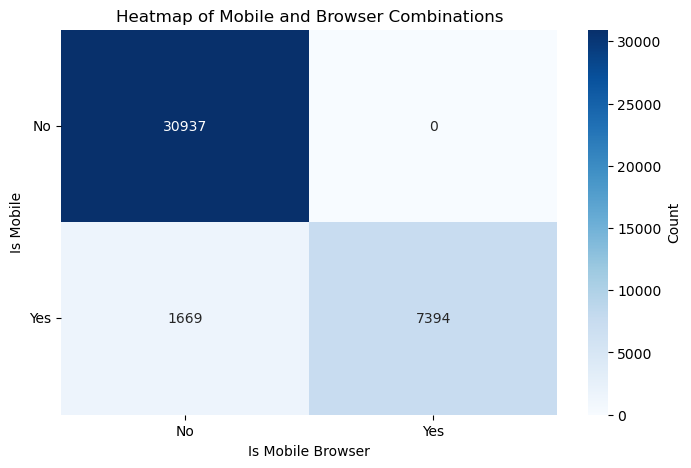

In [22]:
contingency_table = pd.crosstab(df['is_mobile'], df['is_mobile_browser'])

plt.figure(figsize=(8, 5))
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='g', cbar_kws={'label':"Count"})
plt.title("Heatmap of Mobile and Browser Combinations")
plt.xlabel("Is Mobile Browser")
plt.ylabel("Is Mobile")
plt.xticks([0.5, 1.5], ["No", "Yes"], rotation=0)
plt.yticks([0.5, 1.5], ["No", "Yes"], rotation=0)
plt.show()

In [23]:
# this is done here because this change would affect the results of the cell checking for browsers linked to mobile
# the goal of the previous cell is to see if there are any non-mobile browsers
df['browser'] = df['browser'].apply(get_browser_family)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_country,destination_country,browser,os,is_mobile,is_mobile_browser
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2,China,United Kingdom,IE,Windows,False,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3,France,United States,IE,Windows,False,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,United States,None,IE,Windows,False,False


#### Categorical Columns

In [24]:
values_unique = df.nunique()

categorical_possible = values_unique[values_unique < 10]

for col_name, val_count in categorical_possible.items():
    msg = ""
    col_unique_vals = df[col_name].unique()
    
    if val_count == 1:
        col_unique_vals = [x for x in col_unique_vals if not pd.isnull(x)]
        msg = "Removed null value. Possible boolean?"
        
    print(f"{col_name}, Values: {col_unique_vals} {msg}")

protocol, Values: ['ICMP' 'UDP' 'TCP'] 
packet_type, Values: ['Data' 'Control'] 
traffic_type, Values: ['HTTP' 'DNS' 'FTP'] 
malware_indicators, Values: ['IoC Detected'] Removed null value. Possible boolean?
alerts_and_warnings, Values: ['Alert Triggered'] Removed null value. Possible boolean?
attack_type, Values: ['Malware' 'DDoS' 'Intrusion'] 
attack_signature, Values: ['Known Pattern B' 'Known Pattern A'] 
action_taken, Values: ['Logged' 'Blocked' 'Ignored'] 
severity_level, Values: ['Low' 'Medium' 'High'] 
network_segment, Values: ['Segment A' 'Segment B' 'Segment C'] 
firewall_logs, Values: ['Log Data'] Removed null value. Possible boolean?
ids_and_ips_alerts, Values: ['Alert Data'] Removed null value. Possible boolean?
log_source, Values: ['Server' 'Firewall'] 
day_of_week, Values: [1 2 6 4 0 5 3] 
quarter, Values: [2 3 4 1] 
browser, Values: ['IE' 'Firefox' 'Opera' 'Chrome' 'Safari'] 
os, Values: ['Windows' 'Mac OS X' 'Linux' 'iOS' 'Android'] 
is_mobile, Values: [False  True] 
i

---

From the raw data above, we can see that some columns have few unique values. These values can indicate categories and therefore, they can be encoded making it easier for the algorithms to understand.
Both ordinal and nominal encoding should be considered.

Possible fields for ordinal encoding: Severity Level

In addition that that, there are columns that contain only 1 unique value; usually the single value and others are populated by null values. Those columns can be possibly used as booleans.

#### Payload Data Checks

TBD

In [25]:
df['payload_data'].tolist()[10000:10010]

['Eos eligendi occaecati impedit reprehenderit. Mollitia fugit ipsa a. Pariatur reprehenderit impedit quae cum. Amet nihil doloremque.',
 'Ipsa nam sequi ducimus nam fugit. Harum enim veniam.\nIste exercitationem natus temporibus inventore inventore ipsam. Nesciunt temporibus eaque ad odio nihil. Nihil aliquid et blanditiis.',
 'Deleniti quidem tenetur voluptates placeat corporis consectetur. Inventore illo sunt rem ipsam numquam.\nVoluptatibus ad facilis voluptas aperiam a quae. Laboriosam et beatae necessitatibus iste.',
 'Libero illo cupiditate sit. Ipsam recusandae dolores at deserunt.\nPraesentium sed sunt nihil. Veniam sint eum quisquam nesciunt deserunt officia.',
 'Nisi consectetur impedit accusamus aperiam. Quibusdam ea quas incidunt.\nDeleniti quidem suscipit cumque quae. Quidem eligendi natus est similique. Occaecati optio eum rem et deleniti.',
 'Asperiores dolorem nisi. Eligendi aperiam minus laboriosam.\nAliquam esse numquam architecto saepe in.\nProvident accusantium qua

#### Countries

It appears that there is missing data in the countries columns. Investigate.

In [26]:
df[df['destination_country'].isnull()]

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_country,destination_country,browser,os,is_mobile,is_mobile_browser
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,United States,None,IE,Windows,False,False
15,24912,21176,TCP,425,Data,DNS,Voluptates nam doloremque. Eius amet officiis ...,NaN,91.56,Alert Triggered,Intrusion,Known Pattern B,Logged,Medium,Shaan Subramaniam,Segment C,"Bhiwandi, Tripura",NaN,Log Data,NaN,Firewall,20,4,3,United States,None,Opera,Linux,False,False
22,3133,46077,UDP,1425,Data,DNS,Praesentium voluptatibus sapiente.,NaN,72.25,NaN,DDoS,Known Pattern A,Logged,High,Akarsh Khurana,Segment A,"Gaya, Gujarat",169.32.12.215,NaN,Alert Data,Server,6,4,1,Ireland,None,IE,Windows,False,False
42,1031,40417,TCP,1474,Control,HTTP,Impedit itaque debitis repellendus. Reprehende...,IoC Detected,29.66,NaN,DDoS,Known Pattern B,Logged,Low,Trisha Rajagopal,Segment A,"Adoni, Tripura",NaN,NaN,NaN,Firewall,8,3,4,United States,None,Chrome,Android,True,False
43,57124,48417,UDP,1363,Data,FTP,Nulla magnam minima dolor similique tempore as...,IoC Detected,10.75,Alert Triggered,Intrusion,Known Pattern A,Blocked,High,Farhan Mahal,Segment A,"Eluru, Uttarakhand",NaN,Log Data,NaN,Server,20,3,3,United States,None,Safari,Windows,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39972,26324,47911,TCP,973,Control,FTP,Consequatur voluptate nesciunt neque rerum. Di...,IoC Detected,42.05,Alert Triggered,Intrusion,Known Pattern B,Blocked,Low,Shamik Madan,Segment C,"Rourkela, Odisha",101.161.128.16,Log Data,NaN,Server,4,2,1,China,None,Safari,iOS,True,True
39980,56464,14589,UDP,1404,Control,HTTP,Magni suscipit incidunt. Doloremque maxime nul...,IoC Detected,48.89,NaN,Malware,Known Pattern A,Logged,Low,Tejas Rana,Segment A,"Latur, Madhya Pradesh",NaN,NaN,Alert Data,Firewall,19,3,3,China,None,Opera,Windows,False,False
39981,59972,36142,ICMP,926,Data,FTP,Fugiat dolorem nesciunt sint et. Esse eveniet ...,IoC Detected,98.53,NaN,DDoS,Known Pattern B,Blocked,Medium,Zain Saini,Segment B,"Kollam, Rajasthan",NaN,Log Data,NaN,Server,1,2,3,Syria,None,Chrome,Windows,False,False
39986,39932,51961,TCP,895,Control,DNS,Blanditiis culpa delectus. Asperiores quia sae...,NaN,65.36,NaN,Malware,Known Pattern A,Blocked,Low,Ishita Dugal,Segment C,"Farrukhabad, Himachal Pradesh",NaN,NaN,Alert Data,Server,2,0,1,United Arab Emirates,None,Safari,iOS,True,True


#### Class Distribution

For the attack types.

#### Feature Correlation with Attack Type

We can check categorical, then numerical, then both features alongside attack_type.

In [27]:
# df_corr = df.drop(columns=['Timestamp','Source IP Address','Destination IP Address'])
# plt.figure(figsize=(10,10))
# sns.heatmap(df_corr.corr(),annot=True)
# plt.show()

In [28]:
# plt.figure(figsize=(8,5))
# sns.boxplot(x=df[df["Attack Type"]=="Malware"], y=df['Packet Length'], palette="coolwarm")
# # sns.boxplot(x=df.filter('Attack Type'=='Malware'), y=df['Packet Length'], palette="coolwarm")
# plt.title("Packet Length vs Attach Type")
# plt.show()

In [29]:
# numeric_cols = df.select_dtypes(include=['int64','float64']).columns

# for col in numeric_cols:
#     print(f"Valores extremos da coluna {col}:")
#     print("Mínimo:", df[col].min())
#     print("Máximo:", df[col].max())
#     print("-----------")

In [30]:
# import seaborn as sns
# from matplotlib import pyplot as plt

# plt.figure(figsize=(8,5))
# sns.countplot(x=df)
# plt.title("")
# plt.show()